In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def binary_thresholding(image, border = 127):
    binarized_image = image.copy()
    # Change values of the (greyscaled) image below the border to zero and above to 1
    binarized_image[binarized_image < border] = 0
    binarized_image[binarized_image >= border] = 1
    
    return binarized_image

def morphological_erosion(image, structuring_element):
    (image_height, image_width) = image.shape[:2]
    (SE_height, SE_width) = structuring_element.shape[:2]

    # Create black padding for the image:
    x_pad = (SE_width - 1) // 2
    y_pad = (SE_height -1) // 2
    padded_image = cv2.copyMakeBorder(image, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_CONSTANT, 0)
    
    eroded_image = image.copy()
    # Loop over the image and apply erosion at each pixel
    for x in range(x_pad, image_height+x_pad):
        for y in range(y_pad, image_width+y_pad):
            # Get the neighborhood (of same size as the structuring element) of the pixel
            neighborhood = padded_image[x-x_pad:x+x_pad+1, y-y_pad:y+y_pad+1]
            # Subtract the neighborhood from the structuring element
            # if the element of the subtraction matrix is 0 its a match,
            # if its 1 then there should have been foreground but was background (no match)
            # if its -1 or -2 then the structuring element is -1 at that place (dont care vale)
            result_matrix = np.subtract(structuring_element, neighborhood)
            # if the result matrix contains an 1 then its a no match, else a match
            if 1 in result_matrix:
                eroded_image[x-x_pad, y-y_pad] = 0
            else:
                eroded_image[x-x_pad, y-y_pad] = 1

    return eroded_image

def morphological_dilation(image, structuring_element):
    (image_height, image_width) = image.shape[:2]
    (SE_height, SE_width) = structuring_element.shape[:2]

    # Create black padding for the image:
    x_pad = (SE_width - 1) // 2
    y_pad = (SE_height -1) // 2
    padded_image = cv2.copyMakeBorder(image, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_CONSTANT, 0)
    
    dilated_image = image.copy()
    # Loop over the image and apply erosion at each pixel
    for x in range(x_pad, image_height+x_pad):
        for y in range(y_pad, image_width+y_pad):
            # If any element in the neighborhood matches the corresponding element in the
            # structuring_element, paint the pixel
            neighborhood = padded_image[x-x_pad:x+x_pad+1, y-y_pad:y+y_pad+1]
            if (neighborhood == structuring_element).any():
                dilated_image[x-x_pad, y-y_pad] = 1
            else:
                dilated_image[x-x_pad, y-y_pad] = 0

    return dilated_image

def morphological_opening(image, structuring_element):
    eroded_img = morphological_erosion(image, structuring_element)
    opened_img = morphological_dilation(eroded_img, structuring_element)
    
    return opened_img

def morphological_closing(image, structuring_element):
    dilated_img = morphological_dilation(image, structuring_element)
    closed_img = morphological_erosion(dilated_img, structuring_element)
    
    return closed_img

def binary_circular_matrix(radius): # function to create a binary circular matrix
    length = 2 * radius + 1
    x, y = np.mgrid[:length, :length]
    # change values of the grid to the distance of the value from the center by using circle equation
    distance = np.sqrt((x - radius) ** 2 + (y - radius) ** 2)
    # change values with distance lower than the radius to 1 and to 0 else
    distance[distance <= radius] = 1
    distance[distance > radius] = 0
    
    return distance

def plot_images(images, titles):
    # Plot images in rows with matplotlib:
    fig = plt.gcf()
    num_rows = len(images)
    num_columns = len(max(images, key=len))
    for k, row in enumerate(images):
        axes = np.zeros(num_columns, dtype = object)
        axes_count = len(fig.get_axes())
        for i in range(num_columns):
            axes_index = axes_count + i + 1
            axes[i] = fig.add_subplot(num_rows, num_columns, axes_index)
            if i >= len(row): 
                axes[i].set_visible(False)
                continue
            img = row[i]
            axes[i].imshow(img, cmap = plt.cm.gray)
            axes[i].set_title(titles[k][i])

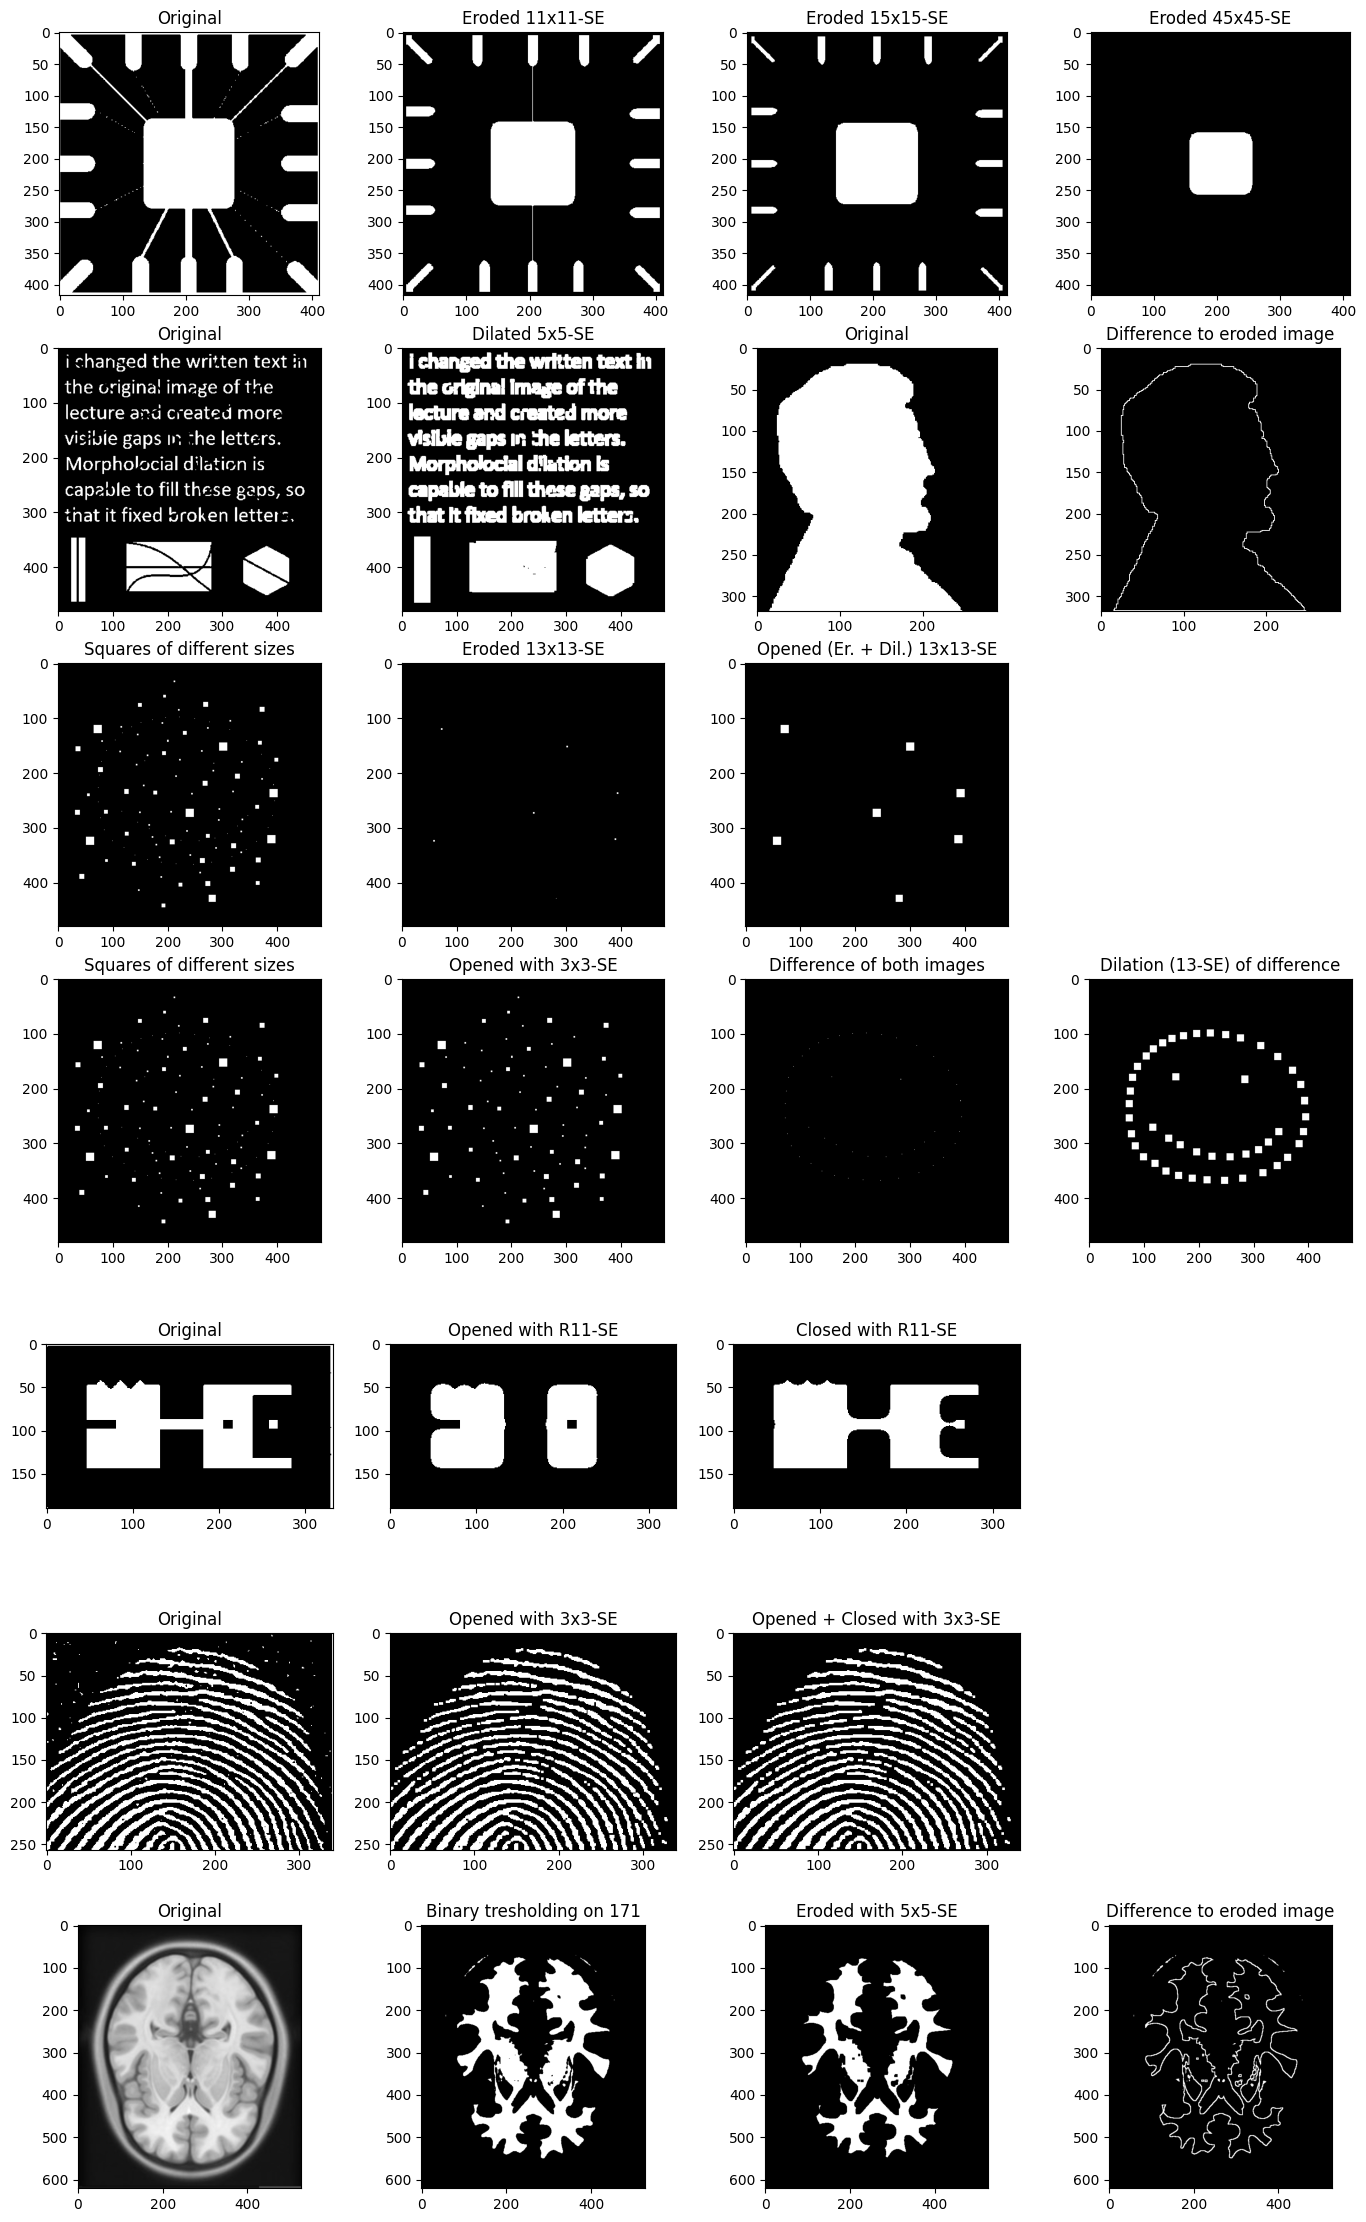

In [6]:

# Load the images and convert them to a binary images

erosion_img = cv2.imread('images/erosion_original.png', cv2.IMREAD_GRAYSCALE)
erosion_img = binary_thresholding(erosion_img)

dilation_img = cv2.imread('images/dilation_original.png', cv2.IMREAD_GRAYSCALE)
dilation_img = binary_thresholding(dilation_img)

squares_img = cv2.imread('images/squares.png', cv2.IMREAD_GRAYSCALE)
squares_img = binary_thresholding(squares_img)

shapes_img = cv2.imread('images/shapes.png', cv2.IMREAD_GRAYSCALE)
shapes_img = binary_thresholding(shapes_img)

fingerprint_img = cv2.imread('images/fingerprint.png', cv2.IMREAD_GRAYSCALE)
fingerprint_img = binary_thresholding(fingerprint_img)

head_img = cv2.imread('images/head.png', cv2.IMREAD_GRAYSCALE)
head_img = binary_thresholding(head_img)

# Binary thresholding with border of 171
brain_img = cv2.imread('images/brain.png', cv2.IMREAD_GRAYSCALE)
binarized_171_brain_img = binary_thresholding(brain_img, 191)

# Apply the morphological filters

eroded_image_11x11 = morphological_erosion(erosion_img, np.ones((11,11)))
eroded_image_15x15 = morphological_erosion(erosion_img, np.ones((15,15)))
eroded_image_45x45 = morphological_erosion(erosion_img, np.ones((45,45)))

dilated_image_5x5 = morphological_dilation(dilation_img, np.ones((5,5)))

squares_eroded_13_image = morphological_erosion(squares_img, np.ones((13,13)))
squares_opened_13_image = morphological_opening(squares_img, np.ones((13,13)))

# Apply opening with 3x3-SE so the 1x1-Squares will be removed
squares_opened_3_image = morphological_opening(squares_img, np.ones((3,3)))
# Take the subtraction with the original image to only have the 1x1 squares
squares_ones_image = np.subtract(squares_img, squares_opened_3_image)
# Make the 1x1 squares bigger by applying dilation with 13x13-SE
squares_ones_dilated_image = morphological_dilation(squares_ones_image, np.ones((13,13)))

# Create circular matrix with radius of 11
R11_matrix = binary_circular_matrix(11)
# change 0 values to -1 (dont care) values
R11_matrix[R11_matrix == 0] = -1

shapes_opened_R11_image = morphological_opening(shapes_img, R11_matrix)
shapes_closed_R11_image = morphological_closing(shapes_img, R11_matrix)

fingerprint_opened_image = morphological_opening(fingerprint_img, np.ones((3,3)))
fingerprint_op_cl_image = morphological_closing(fingerprint_opened_image, np.ones((3,3)))

head_eroded_image = morphological_erosion(head_img, np.ones((3,3)))
head_boundaries_image = np.subtract(head_img, head_eroded_image)

brain_eroded_image = morphological_erosion(binarized_171_brain_img, np.ones((5,5)))
# Take the subtraction to get the boundaries
brain_boundaries_image = np.subtract(binarized_171_brain_img, brain_eroded_image)

# Plot the original and filtered images
fig = plt.figure(figsize = (17, 28))

images = [
    [erosion_img, eroded_image_11x11, eroded_image_15x15, eroded_image_45x45],
    [dilation_img, dilated_image_5x5, head_img, head_boundaries_image],
    [squares_img, squares_eroded_13_image, squares_opened_13_image],
    [squares_img, squares_opened_3_image, squares_ones_image, squares_ones_dilated_image],
    [shapes_img, shapes_opened_R11_image, shapes_closed_R11_image],
    [fingerprint_img, fingerprint_opened_image, fingerprint_op_cl_image],
    [brain_img, binarized_171_brain_img, brain_eroded_image, brain_boundaries_image]
]
titles = [
    ["Original", "Eroded 11x11-SE", "Eroded 15x15-SE", "Eroded 45x45-SE"],
    ["Original", "Dilated 5x5-SE", "Original", "Difference to eroded image"],
    ["Squares of different sizes", "Eroded 13x13-SE", "Opened (Er. + Dil.) 13x13-SE"],
    ["Squares of different sizes", "Opened with 3x3-SE", "Difference of both images", 
     "Dilation (13-SE) of difference"],
    ["Original", "Opened with R11-SE", "Closed with R11-SE"],
    ["Original", "Opened with 3x3-SE", "Opened + Closed with 3x3-SE"],
    ["Original", "Binary tresholding on 171", "Eroded with 5x5-SE", "Difference to eroded image"]
]

plot_images(images, titles)
plt.savefig("Filtered Images.png")
plt.show()